<a href="https://colab.research.google.com/github/HanbumKo/DRL-course/blob/main/supplementary/RLlib_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ray RLlib

이번 노트북에서는 Ray의 라이브러리중 하나인 RLlib에 대해서 살펴보겠습니다.

RLlib은 Ray의 distributed api들을 RL에 적용시킬 수 있도록 조금 더 high-level에서 제공해주며, policy, loss 등을 정의해주면 메인 트레이닝 루프와 환경 혹은 트레이닝을 parallel 하게 돌리는것은 RLlib이 대신해주게 됩니다.

RLlib의 공식 문서를 따라가면서 어떻게 사용하는지 살펴보도록 하겠습니다. (https://docs.ray.io/en/latest/rllib.html)

우선 RLlib을 설치합니다.

In [1]:
!pip install 'ray[rllib]'

     |████████████████████████████████| 49.7MB 65kB/s 
     |████████████████████████████████| 3.1MB 22.8MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 1.3MB 35.5MB/s 
     |████████████████████████████████| 1.0MB 34.2MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 133kB 43.0MB/s 
     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 122kB 43.1MB/s 
     |████████████████████████████████| 1.8MB 34.9MB/s 
     |████████████████████████████████| 36.4MB 82kB/s 
     |████████████████████████████████| 296kB 40.9MB/s 
     |████████████████████████████████| 143kB 45.4MB/s 
     |████████████████████████████████| 92kB 9.8MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-cp37-none-any.whl size=12621 sha256=cfa06b5549699d610b7803c7bf8ffe86123c9f40bcfe3a0c04177e53d0b0b934
  Stored in directory: /root/.cache/pip/wheels/48/b4/d5/fb5b7f1d040f2ff20

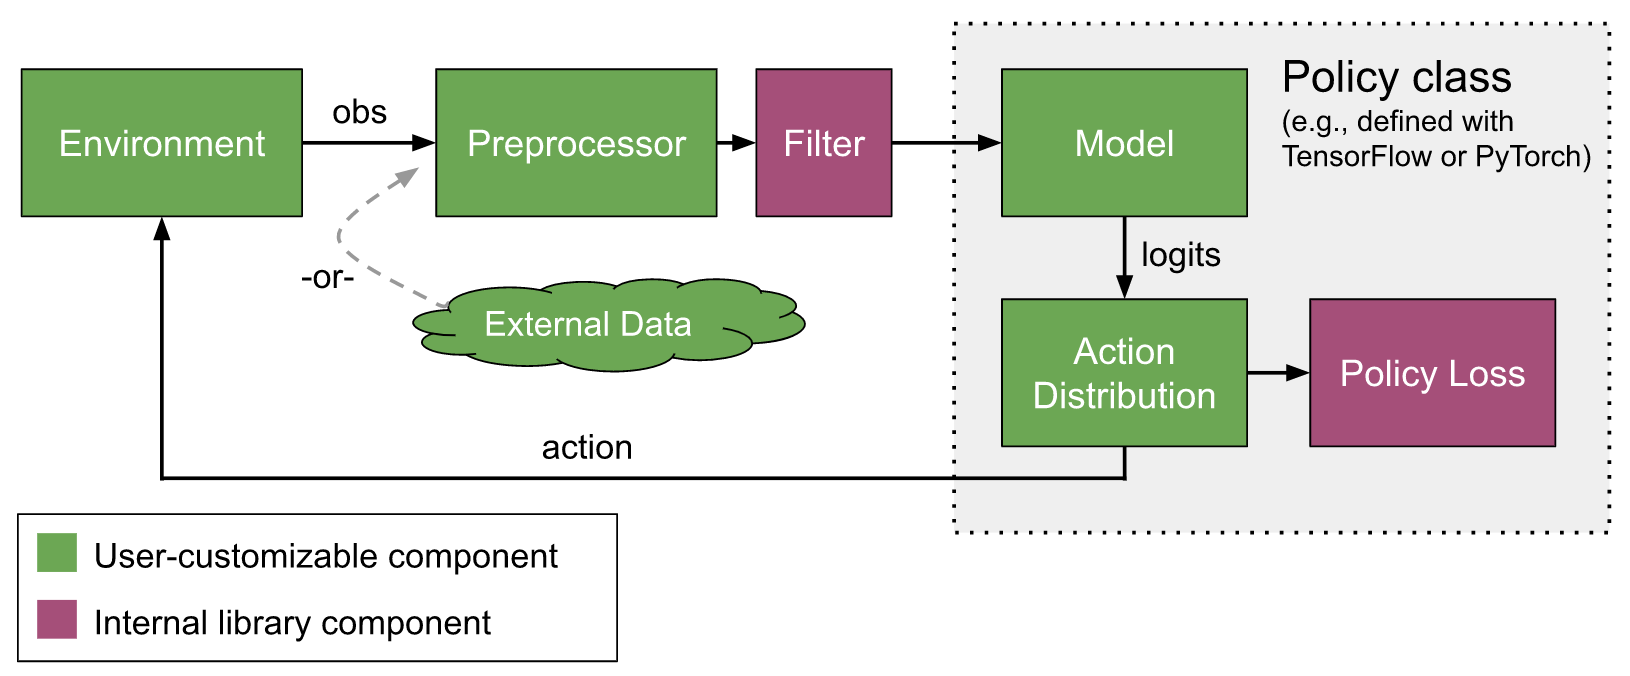

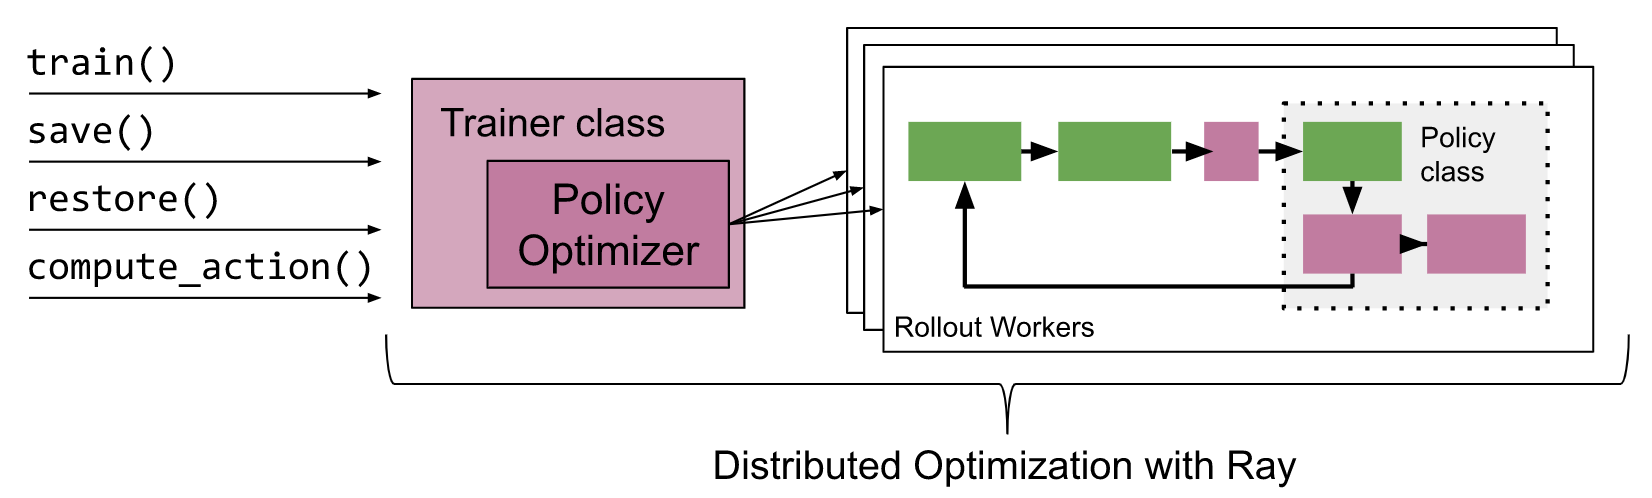

크게 위와같은 구조를 지니고 있습니다. Environment, Policy, Optimizer, Trainer 등을 구현하고 trainer의 네 가지 함수 train(), save(), restore(), compute_action()을 이용하여 학습을 진행하게 됩니다.



# Basic Python API

trainer를 선언하고 사용하는 가장 기본적인 코드를 살펴보겠습니다.

In [ ]:
import ray
import ray.rllib.agents.ppo as ppo
from ray.tune.logger import pretty_print

ray.init()
config = ppo.DEFAULT_CONFIG.copy()
config["num_gpus"] = 0
config["num_workers"] = 1
config["framework"] = "torch"
trainer = ppo.PPOTrainer(config=config, env="CartPole-v0")

for i in range(1000):
    # Perform one iteration of training the policy with PPO
    result = trainer.train()
    print(pretty_print(result))

    if i % 100 == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)


# import model saved
trainer.import_model("my_weights.h5")


RLlib에 구현되어있는 ppo 알고리즘을 사용해 CartPole 환경을 학습하는 코드입니다. Trainer를 선언할때 config을 넣어줄 수 있습니다. config는 위 코드에서는 gpu개수와 worker수, torch를 사용하겠다는 config를 사용한다고 정의해주고 있습니다. 모든 config 내용에 대해서는 [이곳](https://docs.ray.io/en/latest/rllib-training.html#common-parameters)에서 살펴 볼 수 있습니다.

trainer의 train()함수를 실행할때마다 트레이닝의 한 iteration을 진행하게 됩니다.

또한 trainer.save()를 통해 trainer를 저장할 수 있습니다.

# Computing Actions

trainer의 함수중 하나인 compute_action을 이용하는 예제입니다. 위에서 트레이닝한 trainer를 사용해서 CartPole환경에 적용하여 한 에피소드의 리워드를 출력합니다. 잘 트레이닝 된것을 확인할 수 있습니다.

In [7]:
import gym


env = gym.make("CartPole-v0")
# run until episode ends
episode_reward = 0
done = False
obs = env.reset()
while not done:
    action = trainer.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

print("reward :", episode_reward)

reward : 200.0


# Accessing Policy State

trainer로 트레이닝 후 트레이닝된 policy, PyTorch의 경우에는 nn.Module을 상속받는 클래스, 에 접근할 수 있습니다.

In [11]:
# Get weights of the default local policy
policy = trainer.get_policy() # RLlib의 Policy object
policy_model = policy.model # RLlib의 Model object + PyTorch의 Model object (둘 다 상속받는다.)
trained_weights = policy.get_weights() # weight

아래와 같은 정보들도 얻어올 수 있습니다.

In [28]:
import torch
logits, _ = policy.model.from_batch({"obs": torch.Tensor([[0.1, 0.2, 0.3, 0.4]]).cuda()})

distribution_class = policy.dist_class
dist = policy.dist_class(logits, policy.model)

# Get the estimated values for the most recent forward pass
value = policy.model.value_function()

In [32]:
print(logits)
print(distribution_class)
print(dist)
print(dist.sample())
print(value)

tensor([[-4.9101,  4.9052]], device='cuda:0', grad_fn=<AddmmBackward>)
<class 'ray.rllib.models.torch.torch_action_dist.TorchCategorical'>
tensor([1], device='cuda:0')
tensor([-1.5318], device='cuda:0', grad_fn=<SqueezeBackward1>)
<generator object Module.parameters at 0x7fa2e67c1c50>


# Environment

RLlib을 사용해서 트레이닝할 수 있도록 환경을 제작할 수 있습니다. gym.Env를 상속받아서 구현한 environment도 이에 포함됩니다.

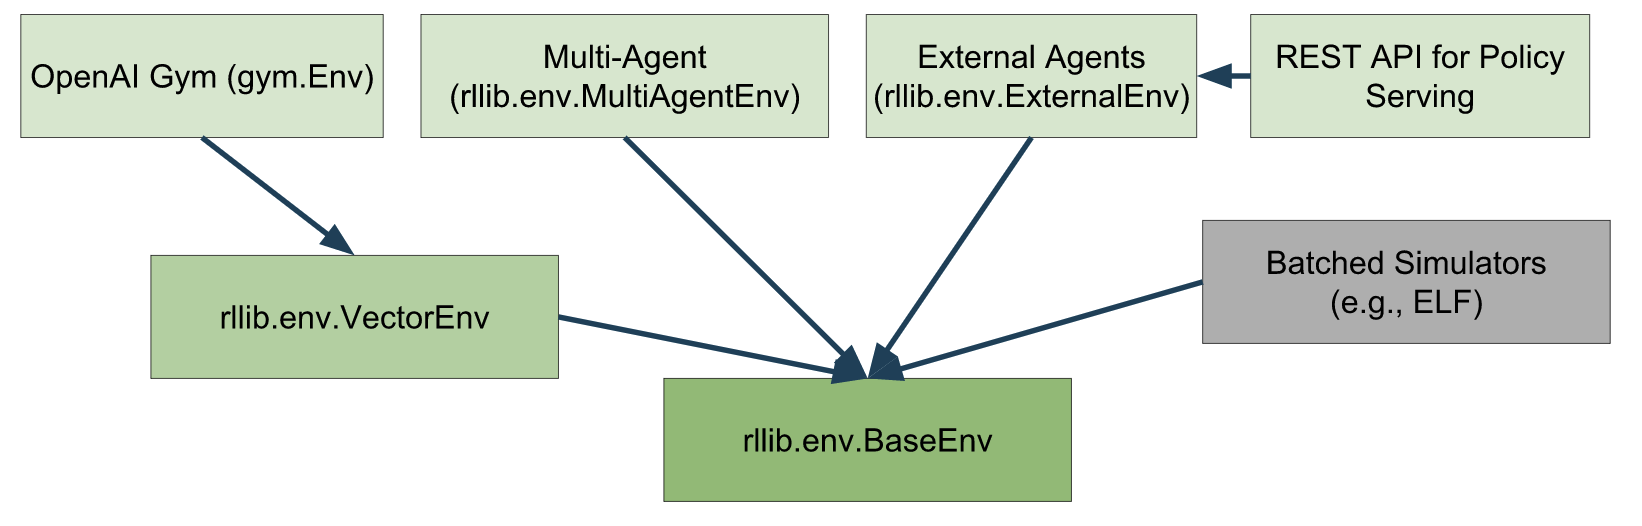

gym.Env를 상속받는 환경을 사용하는 예시입니다.

gym.Env만으로 구현할 수 없는 환경들도 상황에 따라 존재하는데, 이에 대한 설명은 [이곳](https://docs.ray.io/en/latest/rllib-env.html)을 참고하시면 되겠습니다.

In [ ]:
import gym, ray
from ray.rllib.agents import ppo

class MyEnv(gym.Env):
    def __init__(self, env_config):
        self.action_space = <gym.Space>
        self.observation_space = <gym.Space>
    def reset(self):
        return <obs>
    def step(self, action):
        return <obs>, <reward: float>, <done: bool>, <info: dict>

ray.init()
trainer = ppo.PPOTrainer(env=MyEnv, config={
    "env_config": {},  # config to pass to env class
})

while True:
    print(trainer.train())

# Policy

RLlib에서 사용하는 Policy를 구현할때에는 두 가지 방법을 사용할 수 있는데, 첫번째는 Policy를 상속받아 필요한 함수 모두 구현하는 방법, 혹은 build_torch_policy()함수를 이용하는 방법이 있습니다.

첫번째 모두 구현하는 방법은 다음과 같이 Policy 클래스를 상속받아 구현하게 됩니다. 필요한 모든 함수와 이에 대한 설명은 [이곳](https://github.com/ray-project/ray/blob/master/rllib/policy/policy.py)에서 확인할 수 있습니다.

In [ ]:
class CustomPolicy(Policy):
    """Example of a custom policy written from scratch.

    You might find it more convenient to use the `build_tf_policy` and
    `build_torch_policy` helpers instead for a real policy, which are
    described in the next sections.
    """

    def __init__(self, observation_space, action_space, config):
        Policy.__init__(self, observation_space, action_space, config)
        # example parameter
        self.w = 1.0

    def compute_actions(self,
                        obs_batch,
                        state_batches,
                        prev_action_batch=None,
                        prev_reward_batch=None,
                        info_batch=None,
                        episodes=None,
                        **kwargs):
        # return action batch, RNN states, extra values to include in batch
        return [self.action_space.sample() for _ in obs_batch], [], {}

    def learn_on_batch(self, samples):
        # implement your learning code here
        return {}  # return stats

    def get_weights(self):
        return {"w": self.w}

    def set_weights(self, weights):
        self.w = weights["w"]

두번째로 build_torch_policy()를 사용하는 방법입니다. 다음 코드에서는 policy gradient loss 함수를 만들고 build_torch_policy()를 이용하여 policy를 만들게 됩니다. 다른 모든 필요한 함수들에 대한 설명은 [이곳](https://docs.ray.io/en/latest/rllib-concepts.html#building-policies-in-pytorch)과 [이곳](https://github.com/ray-project/ray/blob/master/rllib/policy/torch_policy_template.py)에 설명되어 있습니다.

In [ ]:
from ray.rllib.policy.sample_batch import SampleBatch
from ray.rllib.policy.torch_policy_template import build_torch_policy

def policy_gradient_loss(policy, model, dist_class, train_batch):
    logits, _ = model.from_batch(train_batch)
    action_dist = dist_class(logits)
    log_probs = action_dist.logp(train_batch[SampleBatch.ACTIONS])
    return -train_batch[SampleBatch.REWARDS].dot(log_probs)

# <class 'ray.rllib.policy.torch_policy_template.MyTorchPolicy'>
MyTorchPolicy = build_torch_policy(
    name="MyTorchPolicy",
    loss_fn=policy_gradient_loss)

위의 두 경우처럼 모두 구현하는 방법도 있고, 또는 이전에 잘 구현된 Policy에 필요한 부분만 바꿔 사용할 수 있습니다. 필요한 함수를 구현 후 다음과 같이 with_updates()함수를 사용해 새로운 Policy를 만들어줍니다.

In [ ]:
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.agents.ppo.ppo_tf_policy import PPOTFPolicy

CustomPolicy = PPOTFPolicy.with_updates(
    name="MyCustomPPOTFPolicy",
    loss_fn=some_custom_loss_fn)

CustomTrainer = PPOTrainer.with_updates(
    default_policy=CustomPolicy)

# Trainer

Policy 구현과 비슷하게 Trainer도 구현하여 줄 수 있습니다. 다음은 build_trainer()함수를 이용해 Trainer를 만드는 예제입니다. 이 또한 필요한 모든 함수에 대한 설명과 코드는 [이곳](https://github.com/ray-project/ray/blob/43de7f48a70798e354ed8167e21befcaf678d8a0/rllib/agents/trainer_template.py#L52)에서 확인할 수 있습니다.

In [ ]:
def policy_gradient_loss(policy, model, dist_class, train_batch):
    logits, _ = model({SampleBatch.CUR_OBS: train_batch[SampleBatch.CUR_OBS]})
    action_dist = dist_class(logits, model)
    log_probs = action_dist.logp(train_batch[SampleBatch.ACTIONS])
    return -train_batch[SampleBatch.REWARDS].dot(log_probs)


# <class 'ray.rllib.policy.torch_policy_template.MyTorchPolicy'>
MyTorchPolicy = build_policy_class(
    name="MyTorchPolicy", framework="torch", loss_fn=policy_gradient_loss)

# <class 'ray.rllib.agents.trainer_template.MyCustomTrainer'>
MyTrainer = build_trainer(
    name="MyCustomTrainer",
    default_policy=MyTorchPolicy,
)